# P3
## Desenvolvido e discutido por Felipe Arruda-196862 e Leonardo Koike-

# Evolucionary Model
## Introdução
* The evolutionary model adopted -> Genetic Algorithms
* Variations on parameters -> Population size/Crossover rate/Mutation rate/Generation interval/Stopping criteria
* Fitness function adopted -> combination between max score and has won
* Population size -> population_size
* Stop criteria -> max_generation or population_average hasn`t changed
* Selection technique -> Roulette Method
* Crossover technique -> Single Point Crossover
* Replacement method -> Steady State, bring 10% of the original population among with the children
* Mutation rate -> 0.1
* Crossover rate -> 0.8

Como podemos ver acima, decidimos tomar uma abordagem de algorítmo genético para resolução do problema do Pacman. Algumas informações adicionais sobre o modelo proposto: <br>
* Um individuo é composto de uma série de genes que podem ter o valor 'L' ou 'R', idicando ao pacman se ele deve virar à esquerda ou à direita respectivamente. O número de genes é determinado por um parâmetro passado na criação da população. Um exemplo seria: 'LRRLLLRLRRRL' de um individuo com 12 genes.
* Inicialmente, para a fitness do individuo, pensamos em combinar a pontuação média com um bonus caso o pacman vencesse os mapas, esse bonus seria proporcional à complexidade de cada mapa e arbitrário na linha de código. Entretanto, após testes decidimos seguir com apenas com a pontuação média do individuo como sua fitness.
* As gerações vão mudando até atingir a geração máxima ou a diferença percentual entre uma média de população e sua anterior menor que 1%, mantendo ou aumentando o winrate em relação a geração anterior.
* A seleção dos indivíduos tanto para crossover quanto para mutação é por roleta, garantindo que não tenham valores negativos na fitness aplicando uma máscara com o valor mínimo do vetor. Além disso, utilizamos transformação exponencial na fitness para a seleção.
* O stedy state traz um percentual dos melhores individuos de uma geração para a outra, sem que eles sejam repetidos, ou seja, o mesmo individuo não é colcado na geração filha pelo stedy state.
* Para que o codigo e nosso individuo rode, temos um agente chamado "EvolutionAgent" em "pacmanAgents.py", que basicamente escolhe virar de acordo com a listagem de operações passadas pelos genes do individuo. Caso não seja possível virar, ele continua em frente. Se ele não puder seguir em frente nem virar, ele dá meia volta. Se ele chegar ao final da listagem de passos a serem seguidos, ele retorna ao passo inicial.
* Após uma série de testes, percebemos que nosso indivíduos não estava apto por conta da movimentação randômica dos fantasmas, o que gerava muito problema na evolução do agente. Assim, decidimos por utilizar a flag "-f" na execução do jogo, que fixava o caminho realizado pelo fantasma. Isso resultou na resolução do seguinte problema: qual o melhor caminho que o pacman pode realizar no mapa sem ser interceptado por um fantasma? Ou seja, o pacman deve percorrer os corredores do labirinto, sem ser interceptado pelo fantasma e conseguir a maior quantidade de pontos possível. Como os fantasmas percorrem sempre o mesmo caminho no labirinto, não haveria a necessidade de jogar o jogo multiplas vezes, já que o pacman e o fantasma se inteceptariam sempre no mesmo ponto do jogo.

# Implementação e treino

In [1]:
## Imports
import random
import numpy as np
from statistics import mean
random.seed(10)
maps = ['smallClassic', 'mediumClassic', 'originalClassic']

In [2]:
## Inicialização da população com tamanho passado pelo parâmetro
# retorna a população criada
def population_inicialization(population_size, min_carac, max_carac):
    population = []
    for i in range(population_size):
        len  = random.randint(min_carac, max_carac)
        individuo = ""
        for c in range(len):
            carac = random.randint(1, 100)
            if carac >= 50:
                individuo = individuo + 'L'
            else:
                individuo = individuo + 'R'
        population.append(individuo)
    population = np.array(population)
    return population

In [3]:
# Função para realização de crossover de 1 ponto entre 2 individuos
# retorna os filhos destes individuos
def crossover(l, q):
    # converting the string to list for performing the crossover
    l = list(l)
    q = list(q)
  
# generating the random number to perform crossover
    size_l = len(l)
    size_q = len(q)
    size = 0
    size = min(size_l, size_q)
    k = random.randint(0, size-1)
  
# interchanging the genes
    for i in range(0, k):
        l[i], q[i] = q[i], l[i]
    
    l = ''.join(l)
    q = ''.join(q)
    return l, q

In [4]:
# Função que muta 1 gene de um indivíduo
# Retorna individuo mutado
def mutation(i):
    i = list(i)
    
    x = random.randint(0, len(i)-1)
    if i[x] == 'L':
        i[x] = 'R'
    else:
        i[x] = 'L'
    
    i = ''.join(i)
    return i

In [5]:
#selects 1 or 2 individuals in the population taking into account their fitness
def selection(ind_amount, fitness):
    ind = []

    #section to prevent negative values
    min_val = np.min(fitness)
    if min_val < 0:
        fitness = fitness - min_val

    #Exponential Transformation for the fitness
    fitness = np.sqrt(fitness + 1)

    #Selection
    max_val = np.sum(fitness)
    for n in range(ind_amount):
        pick = random.uniform(0, max_val)
        current = 0
        for i in range(len(fitness)):
            current += fitness[i]
            if current > pick:
                ind.append(i)
                break
    return ind

In [6]:
# Função para mudar a geração, recebe a população pai e gera os filhos
# Retorna uma nova população
def change_generation(population, stedy_rate, mutation_rate, crossover_rate, fitness):
    new_pop = []
    fit_temp = fitness.copy()
    pop_temp = population.copy()

    # stedy state part
    print()
    for i in range(int(stedy_rate*len(population))):
        if population[np.argmax(fitness)] not in new_pop:
            new_pop.append(population[np.argmax(fitness)])
        else: # esse if impede que eu fique repetindo o mesmo individuo muitas vezes pela seleção dos n melhores da população
            i = i - 1 
        fitness = np.delete(fitness, np.argmax(fitness))
        population = np.delete(population, np.argmax(fitness))
        
    
    population = pop_temp
    fitness = fit_temp

    #crossover part
    for i in range(int(crossover_rate*len(population)/2)):
        idx = selection(2, fitness)
        a, b = crossover(population[idx[0]], population[idx[1]])
        new_pop.append(a)
        new_pop.append(b)
    
    #mutation part
    for i in range(int(mutation_rate*len(population))):
        idx = selection(1, fitness)
        new_pop.append(mutation(population[idx[0]]))
    
    new_pop = np.array(new_pop)
    return new_pop

In [7]:
# Função para gerar o fitness da população
# ela joga o jogo com cada indivíduo em cada um dos mapas e gera as métricas do indivíduo após os jogos
# retorna as métricas dessa população
def playGames(population, maps):
    #initializate generation calculations
    population_avgs = []
    population_wins = []

    for i in population:
        i_scores = []
        i_win = []
        for mapa in maps:
            result = !python pacman.py -p EvolutionAgent -a steps=$i -l $mapa -q -f
            is_win = int(result[3].split(':')[1].split('/')[0].replace(" ", ""))
            i_win.append(is_win)
            score = float(result[1].split(':')[1].replace(" ", ""))

            # Esse pedaço de código aumentava a fitness para um individuo que ganhava o jogo
            # if is_win == 1 and mapa == 'smallClassic':
            #     score = score + 150
            # elif is_win == 1 and mapa == 'mediumClassic':
            #     score = score + 500
            # elif is_win == 1 and mapa == 'originalClassic':
            #     score = score + 1200

            i_scores.append(score)

        ind_mean = np.mean(i_scores)
        population_avgs = population_avgs + [ind_mean]
        wins = np.sum(i_win)
        population_wins.append(wins)
        
    population_avgs = np.array(population_avgs)
    population_wins = np.array(population_wins)
    return population_avgs, population_wins

In [8]:
# Função para retornar se o treino ainda deve começar se a média não mudar muito pouco
def checkStopCriteria_avg(current_gen, prev_gen):
    diff = current_gen - prev_gen
    ratio = diff/current_gen
    if ratio < 0:
        ratio = ratio * -1
    if ratio < 0.005:
        return True
    return False

In [9]:
def checkStopCriteria_win(current_gen, prev_gen):
    status = False
    if current_gen >= prev_gen:
        status = True
    return status

In [10]:
# Função para treino da população
def treino(population, maps, max_generation, stedy_rate, mutation_rate, crossover_rate):
    
    #vetor com as populações
    generations =[]
    generations.append(population)

    # valores para avaliação da população
    generation_avg = []
    generation_max_value = []
    generation_max_ind = []
    generation_min_value = []
    generation_win_rate = []

    # variavel que irá controlar o critério de parada do treino
    stop = False

    for g in range(max_generation):
        print("Generation " + str(g))

        # process the fitness for each individual in population
        avgs, wins = playGames(generations[g], maps)

        #calculate the genaration metrics
        generation_max_value.append(np.amax(avgs))
        max_ind_idx = np.where(avgs == generation_max_value[g])
        generation_max_ind.append(generations[g][max_ind_idx[0]])
        generation_min_value.append(np.amin(avgs))
        generation_avg.append(np.mean(avgs))
        total_wins = np.sum(wins)
        total_games = (len(maps)*population.shape[0])
        generation_win_rate.append(total_wins/total_games)
        

        print("Avg = {} \nWin rate = {}\nMax Value = {}\nMin value = {}".format(generation_avg[g], generation_win_rate[g], generation_max_value[g], generation_min_value[g]))
        print("max_ind = {}".format(max_ind_idx))

        

        #Controle para critério de parada do treino
        if g > 0:
            stop = checkStopCriteria_avg(generation_avg[g], generation_avg[g-1]) and checkStopCriteria_win(generation_win_rate[g], generation_win_rate[g-1])
        if stop:
            break

        # se continuar o treino, eu gero a próxima população
        # With the fitness, generate the next population
        next_gen = change_generation(generations[g], stedy_rate, mutation_rate, crossover_rate, avgs)
        generations.append(next_gen)
    return generations, generation_avg, generation_max_value, generation_min_value, generation_win_rate, generation_max_ind


In [11]:
## Parâmetros do primeiro modelo
population_size = 100
max_generation = 1000
stedy_rate = 0.1
mutation_rate = 0.1
crossover_rate = 0.8
min_carac = 4
max_carac = 50
population_1 = population_inicialization(population_size, min_carac, max_carac)

In [12]:
# Treino do primeiro modelo
gen, gen_avg, gen_max_values, gen_min_values, generation_win_rate, gen_max_ind = treino(population_1, maps, max_generation, stedy_rate, mutation_rate, crossover_rate)

Generation 0
Avg = -248.13666666666668 
Win rate = 0.0
Max Value = 31.333333333333332
Min value = -429.6666666666667
max_ind = (array([47], dtype=int64),)

Generation 1
Avg = -204.56666666666663 
Win rate = 0.0
Max Value = 190.0
Min value = -420.3333333333333
max_ind = (array([31], dtype=int64),)

Generation 2
Avg = -160.09090909090907 
Win rate = 0.0
Max Value = 190.0
Min value = -404.6666666666667
max_ind = (array([0], dtype=int64),)

Generation 3
Avg = -133.48387096774195 
Win rate = 0.0033333333333333335
Max Value = 323.6666666666667
Min value = -397.3333333333333
max_ind = (array([71], dtype=int64),)

Generation 4
Avg = -144.92753623188406 
Win rate = 0.0033333333333333335
Max Value = 323.6666666666667
Min value = -397.3333333333333
max_ind = (array([0], dtype=int64),)

Generation 5
Avg = -152.39015151515153 
Win rate = 0.0033333333333333335
Max Value = 323.6666666666667
Min value = -438.0
max_ind = (array([0], dtype=int64),)

Generation 6
Avg = -117.87984496124031 
Win rate = 0.0

In [15]:
## Parâmetros do segundo modelo
population_size = 50
max_generation = 1000
stedy_rate = 0.05
mutation_rate = 0.15
crossover_rate = 0.8
min_carac = 15
max_carac = 30
population_2 = population_inicialization(population_size, min_carac, max_carac)

In [16]:
#  Minor changes and second test, still repeats the individuals
gen_2, gen_avg_2, gen_max_values_2, gen_min_values_2, generation_win_rate_2, gen_max_ind_2 = treino(population_2, maps, max_generation, stedy_rate, mutation_rate, crossover_rate)

Generation 0
Avg = -219.55999999999997 
Win rate = 0.0
Max Value = 254.33333333333334
Min value = -429.0
max_ind = (array([31], dtype=int64),)

Generation 1
Avg = -187.14285714285714 
Win rate = 0.0
Max Value = 254.33333333333334
Min value = -416.3333333333333
max_ind = (array([0], dtype=int64),)

Generation 2
Avg = -160.34042553191492 
Win rate = 0.0
Max Value = 254.33333333333334
Min value = -340.6666666666667
max_ind = (array([0], dtype=int64),)

Generation 3
Avg = -96.71111111111111 
Win rate = 0.0
Max Value = 254.33333333333334
Min value = -359.0
max_ind = (array([ 0, 12], dtype=int64),)

Generation 4
Avg = -92.37209302325581 
Win rate = 0.0
Max Value = 309.6666666666667
Min value = -322.6666666666667
max_ind = (array([12], dtype=int64),)

Generation 5
Avg = -14.928571428571429 
Win rate = 0.0
Max Value = 309.6666666666667
Min value = -380.6666666666667
max_ind = (array([ 0, 34], dtype=int64),)

Generation 6
Avg = 8.393162393162392 
Win rate = 0.006666666666666667
Max Value = 316.

# Gráficos dos treinos obtidos acima

In [19]:
import matplotlib.pyplot as plt

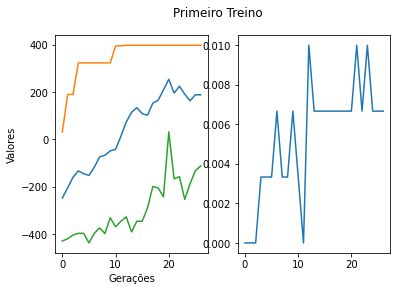

<Figure size 960x480 with 0 Axes>

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Primeiro Treino')
fig = plt.figure(figsize=(12, 6), dpi=80)


ax2.plot(generation_win_rate)


ax1.plot(gen_avg, label = "media")
ax1.plot(gen_max_values, label = "max")
ax1.plot(gen_min_values, label = "min")

ax1.set(xlabel='Gerações', ylabel='Valores')
plt.show()

In [47]:
# Melhor individuo da primeira geração:
gen_max_ind[26][0]

'RLRLRLLRRLLLLLRLLRLRLRLLLLRR'

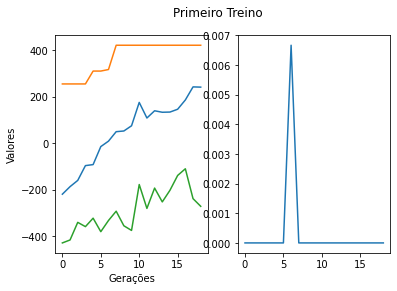

<Figure size 960x480 with 0 Axes>

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Primeiro Treino')
fig = plt.figure(figsize=(12, 6), dpi=80)


ax2.plot(generation_win_rate_2)


ax1.plot(gen_avg_2, label = "media")
ax1.plot(gen_max_values_2, label = "max")
ax1.plot(gen_min_values_2, label = "min")

ax1.set(xlabel='Gerações', ylabel='Valores')
plt.show()

In [45]:
# Melhor individuo da primeira geração:
gen_max_ind_2[18][0]

'RRRLRLRRLRRRLLRRLRLLRRLRRLLL'

# Conclusões do genetic algorithm desenvolvido
* Melhores individuos de cada uma respectivamente: RLRLRLLRRLLLLLRLLRLRLRLLLLRR(28) e RRRLRLRRLRRRLLRRLRLLRRLRRLLL(28). É interessante perceber que ambas as configurações convergiram para um máximo bem próximo e com um tamanho de indivíduo igual.
* High score do primeiro individuo de 398 pontos e do segundo de 420 pontos
* As médias das populações ao final também foram bem próximas. Mas a primeira teve um ponto em que o valor mínimo teve um pico acima de 0.
* O winrate da primeira geração teve um maior número de modificações ao longo das populações.
* Apesar da parametrização e diversos testes, não conseguimos uma boa solução para o problema proposto utilizando este modelo desenvolvido.

## Problemas com o modelo desenvolvido e impedimentos:
* Como os labirintos tem formas muito diferentes, era muito difícil criar um indivíduo generalista para os 3 mapas testados. Alguns desses mapas possuíam corredores ou curvas inúteis, que o agente sempre tomava por não levar em conta a melhor pontuação para tomar sua próxima ação. Além disso, um agente que iria muito bem em um mapa, poderia ficar em um loop em outro mapa tomando os mesmos conjuntos de ações, desse modo ele apenas esperava sua morte por um fantasma em um dos mapas, mesmo indo extremamente bem em outro.
* Não levar em conta a posição dos fantasmas foi um problema, já que o pacman não tomava uma rota de fuga caso o fantasma se aproximasse dele. Dessa forma, existiam indivíduos que apenas seguiam de encontro a um fantasma ou realmente realizavam um caminho de seguir o fantasma a 1 bloco de distância, mesmo não tendo consumido a "power pill", o que pode configurar jogadas bem arriscadas e com baixa probabilidade de sobrevivência.
* Ao longo de nossos testes inciais, permitiamos um grande número de repetições de indivíduos em uma população. Nesses testes até conseguimos um bom resultado, as não significou uma boa população:
> Generation 43 <br>
> Avg = 350.86 <br>
> Win rate = 0.2633333333333333 <br>
> Max Value = 585.0 <br>
> Min value = -354.3333333333333 <br>
 max_score = 585.0 ind = (array([95], dtype=int64),): ['RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRR'] <br><br>
Apesar de ter um win rate de mais de 1 em cada 4 jogos, essa população obteve esse resultado por conta de 1 indivíduo que dominou praticamente 60% da população e ganhava em apenas 1 mapa. Isso se demonstrou um problema de overfitting, já que a população inteira era especialista em vencer 1 dos mapas.
* Todos os nossos testes acabaram levando para um máximo local, onde um individuo ganhava ou conseguia muitos pontos em um dos mapas, mas não conseguia ter sucesso nos outros mapas testados.

## Soluções pensadas
* A repetição de individuos tem que ser limitada, para que o algoritmo consiga continuar explorando novas possibilidades para os demais mapas.
* O agente criado deveria ser modificado para levar em conta outras ações do jogo além de apenas virar, para que o pacman possa realmente tomar a melhor decisão na hora de se locomover pelo labirinto, evitando encontros com o fantasma e curvas desnecessárias.
* Acredito que um individuo generalista para os 3 mapas seja muito difícil de ser encontrado pela diferença e complexidade dos mapas, se separassemos o problema em achar o melhor pacman para cada um dos mapas teriamos um melhor resultado.

## Ponto interessante observado
* Ao longo dos treinos inciais, pudemos observar o poder de uma mutação. O contexto do output abaixo: um individuo estava dominando a população e acabou sendo escolhido para realizar uma mutação. A mutação de 1 gene seu alterou o caminho realizado pelo pacman de forma que a pontuação média atingida foi maior que o individuo gerador, acabando com a dominância de maior média do individuo original. Podemos ver o trecho abaixo:
> Generation 42 <br>
Avg = 364.3500000000001 <br>
Win rate = 0.28 <br>
Max Value = 539.0 <br>
Min value = -354.3333333333333 <br>
max_score = 539.0 ind = (array([ 0,  1,  2,  3,  4,  5,  6,  7, 18, 26, 30, 36, 48, 51, 53, 56, 70],
      dtype=int64),): ['RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'] <br>

> Generation 43 <br>
Avg = 350.86  <br>
Win rate = 0.2633333333333333 <br>
Max Value = 585.0 <br>
Min value = -354.3333333333333 <br>
max_score = 585.0 ind = (array([95], dtype=int64),): ['RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRR'] <br>
podemos saber que o individuo cirado foi originado de mutação pela sua posição no vetor: os 10 primeiros eram de stedy state, seguido por 80 individuos gerados por crossoveer e os últimos 10 eram gerados por mutação.

# Reinforcement Learning:
## Introdução
* The MDP formulation (states, actions, reward function)
* The discretization model adopted
* The number of training episodes
* The stop criteria
* The learning rate value and other parameter values used <br>
:(

# Comparative
:(